In [2]:
import os
#os.chdir('/content/drive/MyDrive/transformer-master')
#os.chdir('/home/rustem/trainee/reports/3/arima_lstm_transformer/')
os.chdir('C:/Users/rustem.kamilyanov/trainee/reports/3/arima_lstm_transformer')

In [ ]:
! pip install yfinance

In [6]:
import yfinance as yf

import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# plt.style.use('seaborn-dark')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns

# from tst import Transformer
# from tst.loss import OZELoss
# from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [7]:
#data = yf.download('AAPL', '2019-01-01', '2021-01-01')
data = yf.download('ETH-USD', '2019-01-01', '2021-01-01')

ts = data['Close']
len(ts)

[*********************100%***********************]  1 of 1 completed


728

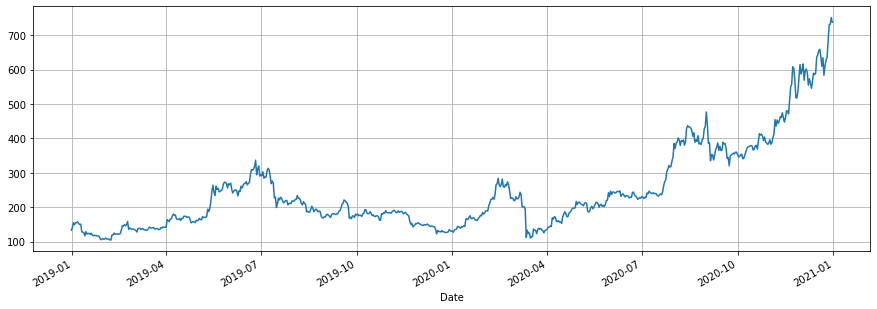

In [8]:
plt.figure(figsize=(15, 5))
ts.plot(grid=True);

# Data preproc

In [9]:
class DiffInv():
    
    def __init__(self, k, series):
      self.k = k
      self.series = series

    def diff(self):
      self.d1 = None
      self.d2 = None
      self.d1 = self.series[1:].values - self.series[:-1].values
      self.d2 = self.d1[1:] - self.d1[:-1]

      if self.k == 2:
        self.out = self.d2
      elif self.k == 1:
        self.out = self.d1
      return pd.Series(self.out)
    
    def inverse(self, diff_data):
      self.inv1 = None
      self.inv2 = None
      self.diff_data = diff_data
      
      if self.k == 2:
        self.inv1 = pd.Series(self.d1[0]).append(pd.Series(self.diff_data)).reset_index(drop=True).cumsum()
        self.inv2 = pd.Series(self.series[0]).append(self.inv1).reset_index(drop=True).cumsum()
        self.out = self.inv2
      elif self.k == 1:
        self.out = pd.Series(self.series[0]).append(pd.Series(self.diff_data)).reset_index(drop=True).cumsum()
      return self.out

In [10]:
from torch.utils.data import Dataset

class edDataset(Dataset):
    def __init__(self, sample, labels) -> None:
        super(edDataset, self).__init__
        
        self.sam = torch.tensor(sample, dtype=torch.float)
        self.lab = torch.tensor(labels, dtype=torch.float)
        
    def __len__(self):
        return len(self.sam)
    
    def __getitem__(self, idx):
        return self.sam[idx], self.lab[idx]

In [11]:
class edDataset_allData(Dataset):
    def __init__(self, sample) -> None:
        super(edDataset_allData, self).__init__
        
        self.sam = torch.tensor(sample, dtype=torch.float)
        
    def __len__(self):
        return len(self.sam)
    
    def __getitem__(self, idx):
        return self.sam[idx]

In [12]:
from torch.utils.data import DataLoader
    
class dlDataset(object):
    
    def __init__(self, ts, batch_size, sample_length, labels_length) -> None:
        self.samples_train = None
        self.labels_train = None
        self.samples_test = None
        self.labels_test = None
        self.samples_all = None
        self.batch_size = batch_size    
        
        train, test = ts[:-90], ts[-90:]
        
        #train samples, labels
        samples_train = []
        labels_train = []
        a = 0
        b = sample_length
        for i in range(len(train)-sample_length-labels_length):
            samples_train.append([train[a:b].values])
            labels_train.append([train[b:b+labels_length].values])
            a += 1
            b += 1
        self.samples_train, self.labels_train = samples_train, labels_train
        
        #test samples, labels
        samples_test = []
        labels_test = []
        a = 0
        b = sample_length
        for i in range(len(test)-sample_length-labels_length):
            samples_test.append([test[a:b].values])
            labels_test.append([test[b:b+labels_length].values])
            a += 1
            b += 1
        self.samples_test, self.labels_test = samples_test, labels_test

        # samples allData
        samples_all = []
        a = 0
        b = sample_length
        for i in range(len(ts)-sample_length):
            samples_all.append([ts[a:b].values])
            a += 1
            b += 1
        self.samples_all = samples_all        
    
    def __MinMax(self, ts, feature_range=(-1, 1)):
        min = feature_range[0]
        max = feature_range[1]
        X_std = (ts - ts.min()) / (ts.max() - ts.min())
        X_scaled = X_std * (max - min) + min
        return X_scaled
        
    def get_train(self):
        dataset = edDataset(self.samples_train, self.labels_train)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    
    def get_test(self):
        dataset = edDataset(self.samples_test, self.labels_test)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
    
    def get_all(self):
        dataset = edDataset_allData(self.samples_all)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

# MSE metric

In [13]:
@torch.no_grad()
def metric(model, test_loader):
    _mse = []

    for x, y in test_loader:
        y_hat = model(x.to(device))
        mse = mean_squared_error(y_true=y.view(-1).tolist(), y_pred=y_hat.view(-1).tolist())
        _mse.append(mse)
    return sum(_mse) / len(_mse)

# Тип случайного процесса

In [14]:
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt

#### Структура и ACF, PACF исходного ряда

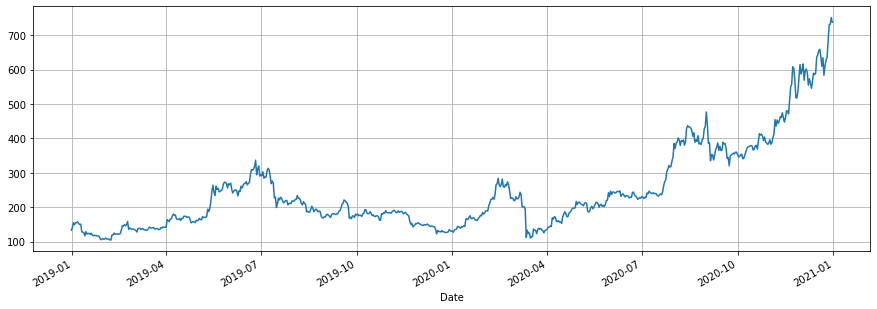

In [15]:
ts_d1 = diff(ts, k_diff=1)
ts_d2 = diff(ts, k_diff=2)

plt.figure(figsize=(15, 5))
ts.plot(grid=True);

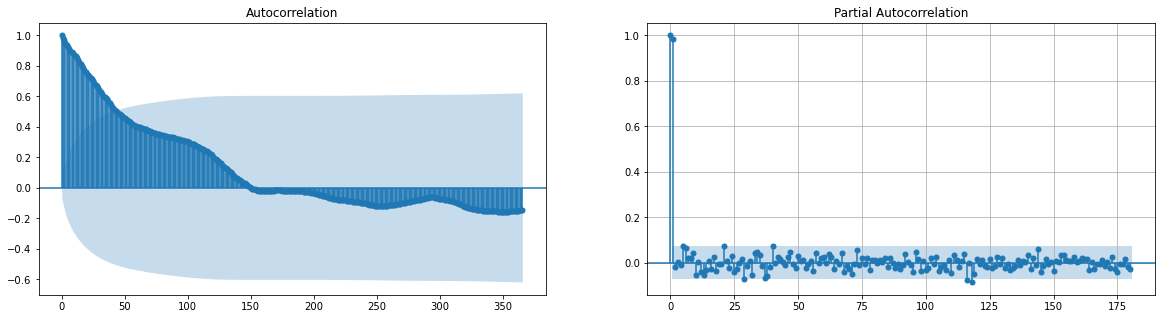

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plot_acf(ts, ax=ax[0], lags=365, title='Autocorrelation')
plot_pacf(ts, ax=ax[1], lags=180, title='Partial Autocorrelation', method='ywmle')
plt.grid(True)
plt.show()

TS + DS(I(1))

In [17]:
# выполняется
adfstat, pvalue, critvalues, resstore = adfuller(ts_d1, 
                                                regression='ct', 
                                                autolag='AIC', 
                                                regresults=True)

print("ADF Statistic:", adfstat)
print("P-Value:", pvalue)
print("Critical values:", critvalues)
print(resstore.resols.summary())

ADF Statistic: -5.507324672443321
P-Value: 2.2289483321194796e-05
Critical values: {'1%': -3.9716505034573073, '5%': -3.41672695453202, '10%': -3.130720261176393}
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     39.42
Date:                Tue, 16 Nov 2021   Prob (F-statistic):          5.81e-106
Time:                        12:04:40   Log-Likelihood:                -2742.6
No. Observations:                 706   AIC:                             5531.
Df Residuals:                     683   BIC:                             5636.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

TS + DS(I(0))

In [18]:
# НЕ выполняется
adfstat, pvalue, critvalues, resstore = adfuller(ts,
                                                  regression='ct', 
                                                  autolag='AIC', 
                                                  regresults=True)
print("ADF Statistic:", adfstat)
print("P-Value:", pvalue)
print("Critical values:", critvalues)
#print(resstore.resols.summary())

ADF Statistic: -0.11518021171114413
P-Value: 0.9928600351140958
Critical values: {'1%': -3.971632203290344, '5%': -3.4167181068447023, '10%': -3.130715058557444}


DS(I(2)) без константы и тренда

In [19]:
# ***выполняется
adfstat, pvalue, critvalues, resstore = adfuller(ts_d2,
                                                  regression='nc', 
                                                  autolag='AIC', 
                                                  regresults=True)

print("ADF Statistic:", adfstat)
print("P-Value:", pvalue)
print("Critical values:", critvalues)
print(resstore.resols.summary())

ADF Statistic: -8.628729103762756
P-Value: 1.2037075043183164e-14
Critical values: {'1%': -2.5689186449373773, '5%': -1.9413876740849187, '10%': -1.6164486505159599}
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.851
Model:                            OLS   Adj. R-squared (uncentered):              0.846
Method:                 Least Squares   F-statistic:                              186.0
Date:                Tue, 16 Nov 2021   Prob (F-statistic):                   4.90e-266
Time:                        12:04:46   Log-Likelihood:                         -2753.0
No. Observations:                 705   AIC:                                      5548.
Df Residuals:                     684   BIC:                                      5644.
Df Model:                          21                                                  
Covariance Type:            nonrobust     

DS(I(2)) с константой

In [20]:
# НЕ выполняется
adfstat, pvalue, critvalues, resstore = adfuller(ts_d2, 
                                                  autolag='AIC',
                                                  store = True, 
                                                  regresults=True)
print("ADF Statistic:", adfstat)
print("P-Value:", pvalue)
print("Critical values:", critvalues)
#print(resstore.resols.summary())

ADF Statistic: -8.631202281018235
P-Value: 5.749188764573847e-14
Critical values: {'1%': -3.4396596024765795, '5%': -2.86564834926679, '10%': -2.568957779286756}


DS(I(1)) без константы

In [21]:
# выполняется
adfstat, pvalue, critvalues, resstore = adfuller(ts_d1,
                                                  regression = 'nc',
                                                  autolag = 'AIC',
                                                  store = True,
                                                  regresults = True)



print("ADF Statistic:", adfstat)
print("P-Value:", pvalue)
print("Critical values:", critvalues)
#print(resstore.resols.summary())

ADF Statistic: -4.911734455044699
P-Value: 1.570522817119787e-06
Critical values: {'1%': -2.56891413228579, '5%': -1.94138711564732, '10%': -1.6164491689879028}


DS(I(1)) с константой

In [22]:
# НЕ выполняется
adfstat, pvalue, critvalues, resstore = adfuller(ts_d1,
                                                  regression = 'c',
                                                  autolag = 'AIC',
                                                  store = True,
                                                  regresults = True)



print("ADF Statistic:", adfstat)
print("P-Value:", pvalue)
print("Critical values:", critvalues)
#print(resstore.resols.summary())

ADF Statistic: -5.205033076022468
P-Value: 8.586430374666937e-06
Critical values: {'1%': -3.439646367660705, '5%': -2.8656425177031375, '10%': -2.5689546724554404}


DS(I(0)) без константы

In [23]:
# НЕ выполняется
adfstat, pvalue, critvalues, resstore = adfuller(ts,
                                                  regression = 'nc',
                                                  autolag = 'AIC',
                                                  store = True,
                                                  regresults = True)



print("ADF Statistic:", adfstat)
print("P-Value:", pvalue)
print("Critical values:", critvalues)
#print(resstore.resols.summary())

ADF Statistic: 1.8992330829429558
P-Value: 0.9871471990252837
Critical values: {'1%': -2.5689096324289933, '5%': -1.941386558815444, '10%': -1.6164496860141153}


DS(I(0)) с константой

In [24]:
# НЕ выполняется
adfstat, pvalue, critvalues, resstore = adfuller(ts,
                                                  regression = 'c',
                                                  autolag = 'AIC',
                                                  store = True,
                                                  regresults = True)



print("ADF Statistic:", adfstat)
print("P-Value:", pvalue)
print("Critical values:", critvalues)
#print(resstore.resols.summary())

ADF Statistic: 1.057429121919483
P-Value: 0.9948364090041883
Critical values: {'1%': -3.439633170421852, '5%': -2.8656367026715337, '10%': -2.5689515744354794}


### ACF, PACF diff 1

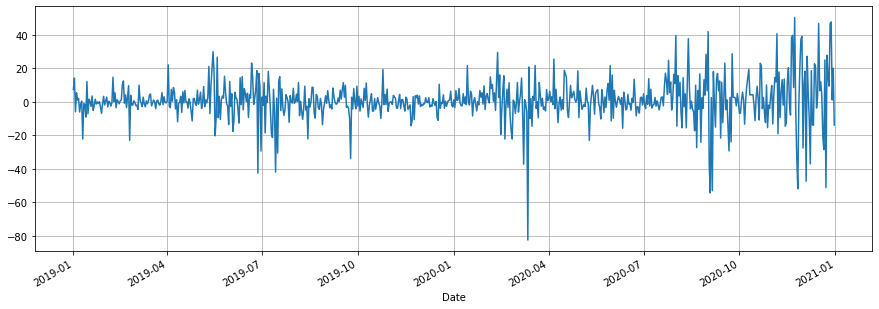

In [20]:
ts_d1 = diff(ts, k_diff=1)

plt.figure(figsize=(15, 5))
ts_d1.plot(grid=True);

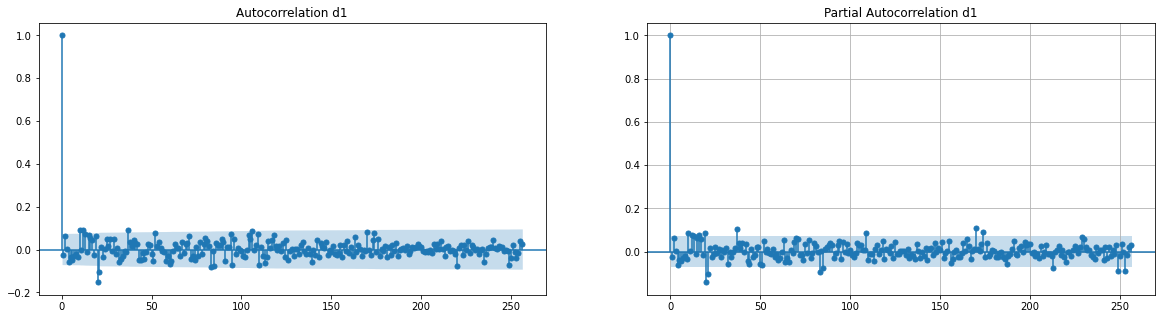

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plot_acf(ts_d1, ax=ax[0], lags=256, title='Autocorrelation d1')
plot_pacf(ts_d1, ax=ax[1], lags=256, title='Partial Autocorrelation d1', method='ywmle')
plt.grid(True)
plt.show()

### ACF, PACF diff 2

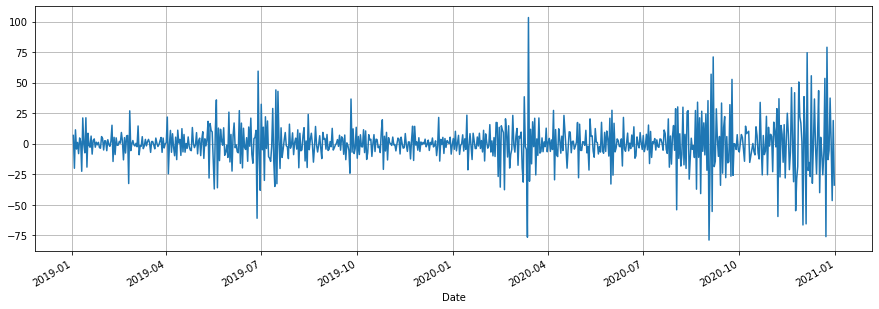

In [22]:
ts_d2 = diff(ts, k_diff=2)

plt.figure(figsize=(15, 5))
ts_d2.plot(grid=True);

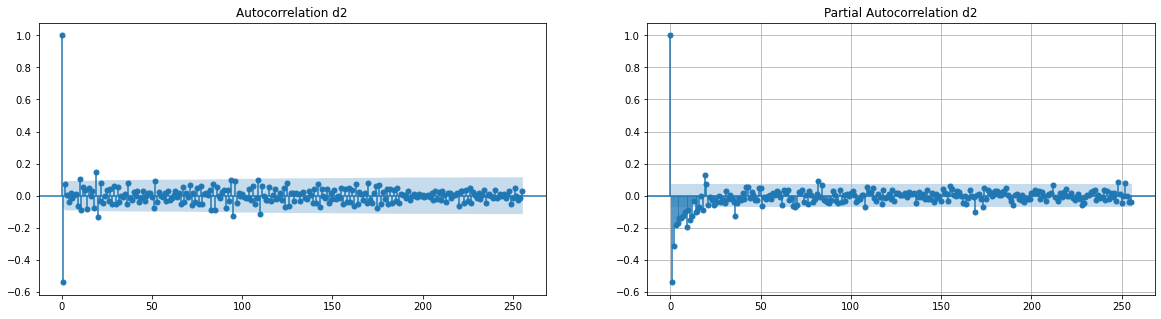

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plot_acf(ts_d2, ax=ax[0], lags=255, title='Autocorrelation d2')
plot_pacf(ts_d2, ax=ax[1], lags=255, title='Partial Autocorrelation d2', method='ywmle')
plt.grid(True)
plt.show()

# ARIMA

C:\Users\rustem.kamilyanov\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\rustem.kamilyanov\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

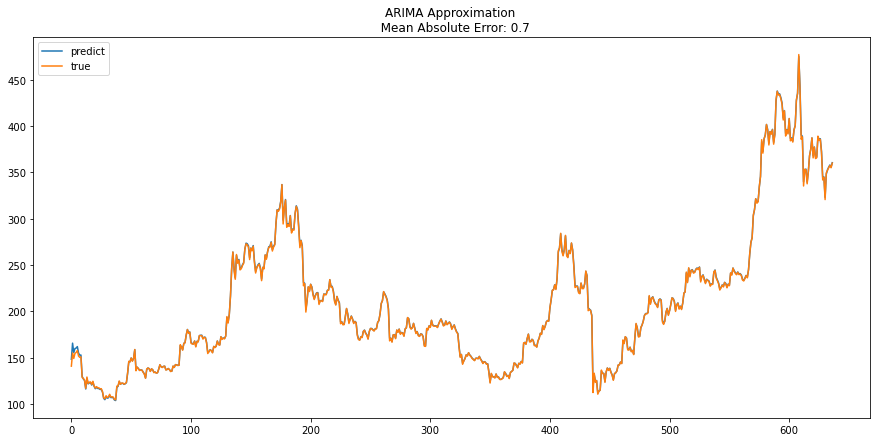

In [25]:
train = ts[:-90]
test = ts[-90:]

model_arima = ARIMA(endog=train.values, order=(1, 2, 1))
result = model_arima.fit()



actual_predict = result.predict(start=2, end=len(train), typ='levels')
true_labels = train[1:]

plt.figure(figsize=(15,7))
plt.plot(actual_predict, label='predict')
plt.plot(true_labels.values, label='true')
plt.title(f'ARIMA Approximation \n  Mean Absolute Error: {mean_absolute_error(true_labels.values, actual_predict):.1f}')
plt.legend();

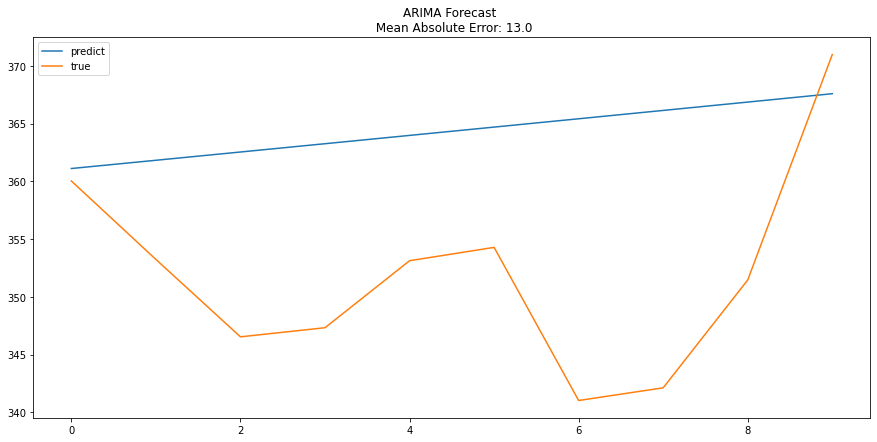

In [26]:
actual_predict = result.predict(start=2, end=len(train)+10, typ='levels')
actual_predict = actual_predict[-10:]
true_labels = test[:10]

plt.figure(figsize=(15,7))
plt.plot(actual_predict, label='predict')
plt.plot(true_labels.values, label='true')
plt.title(f'ARIMA Forecast \n Mean Absolute Error: {mean_absolute_error(true_labels.values, actual_predict):.1f}')
plt.legend();

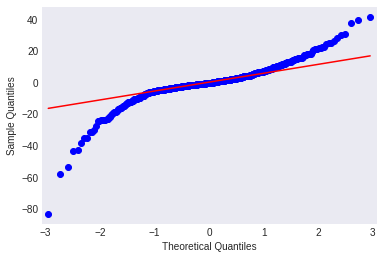

In [32]:
residuals = model_arima.geterrors(result.params)
qqplot(residuals, line='q');

# Transformer

In [33]:
#train pipe
def train_pipeline(model, optimizer, loss_func, dataloader, num_epochs):
    loss_history_epoch = []
    loss_history_all_batch = []
    metric_history_epoch = [] #MAPE

    test_loader = dataloader.get_test()

    for idx_epoch in range(num_epochs):
        model.train()
        train_loader = dataloader.get_train()

        loss_history_batch = []

        for x, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(x.to(device))

            loss = loss_func(y_hat.view(-1), y.to(device).view(-1))
            loss.backward()
            optimizer.step()

            loss_history_batch.append(loss.item())
            loss_history_all_batch.append(loss.item())
        
        # Eval
        model.eval()
        mape = metric(model=model, test_loader=test_loader)
        
        metric_history_epoch.append(mape)
        loss_history_epoch.append(sum(loss_history_batch)/len(loss_history_batch))

        if idx_epoch%5==0:
            print(f'[Epoch #{idx_epoch}], LOSS: {loss_history_epoch[idx_epoch]:.3f}, MSE: {metric_history_epoch[idx_epoch]:.2f}')
            plt.figure(figsize=(15,5))
            plt.plot(loss_history_epoch, label='LOSS')
            plt.plot(metric_history_epoch, label='MSE')
            plt.legend()
            plt.show()

    return loss_history_epoch, loss_history_all_batch, metric_history_epoch

In [ ]:
# params
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
sample_length = 70
labels_length = 5

lr = 2e-3
num_epochs = 500

d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 70 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
pe_period = None
chunk_mode = None

d_input = 70 # From dataset
d_output = 5 # From dataset


scaler = MinMaxScaler(feature_range=(-1, 1))
ts_scale = scaler.fit_transform(ts.values.reshape(-1, 1))
ts_scale = pd.Series(ts_scale.reshape(-1))

dataloader = dlDataset(ts=ts_scale, batch_size=batch_size, sample_length=sample_length,
                       labels_length=labels_length)


# Load transformer with Adam optimizer and MSE loss function
model = Transformer(d_input=d_input, d_model=d_model, d_output=d_output,
                    q=q, v=v, h=h, N=N,
                    attention_size=attention_size, dropout=dropout,
                    chunk_mode=chunk_mode, pe=pe,pe_period=pe_period).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = OZELoss(alpha=0.3)


loss_history_epoch, loss_history_all_batch, metric_history_epoch = train_pipeline(model=model,
                                                                                  optimizer=optimizer,
                                                                                  loss_func=loss_func,
                                                                                  dataloader=dataloader,
                                                                                  num_epochs=num_epochs)


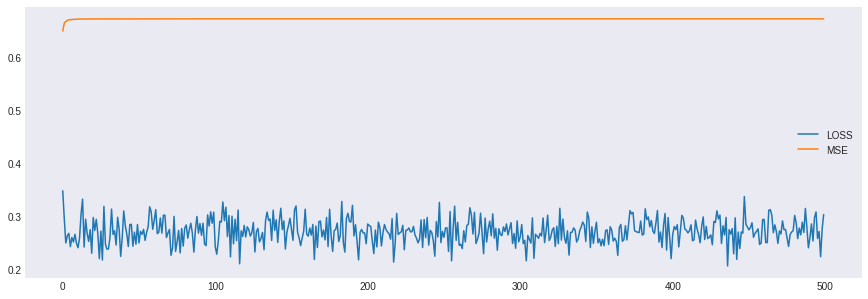

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(loss_history_epoch, label='LOSS')
plt.plot(metric_history_epoch, label='MSE')
plt.legend()

###Прогноз

In [ ]:
dataloader_test = dataloader.get_test()
#preds = np.empty(shape=(len(dataloader_test.dataset), 168, 8))
preds = np.empty(shape=(len(dataloader_test.dataset), 1, d_output))

idx_prediction = 0
with torch.no_grad():
    for x, y in dataloader_test:
        netout = model(x.to(device)).cpu().numpy()
        preds[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

actual_predict = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
true_labels = scaler.inverse_transform(ts[-90:].values.reshape(-1, 1))

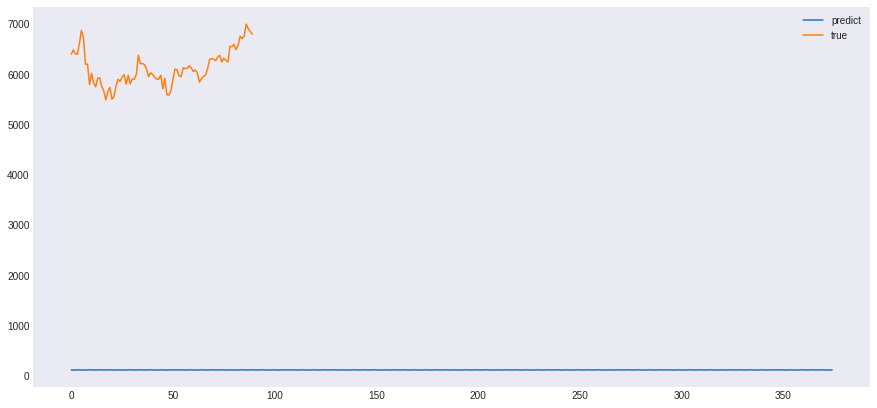

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(actual_predict, label='predict')
plt.plot(true_labels, label='true')
plt.legend();

# LSTM

In [30]:
from IPython.display import clear_output
def train_pipeline(model, optimizer, loss_func, dataloader, num_epochs, num_layers, bidirectional):
    loss_history_epoch = []
    loss_history_all_batch = []
    metric_history_epoch = [] #MAPE

    test_loader = dataloader.get_test()

    for idx_epoch in range(num_epochs):
        model.train()
        train_loader = dataloader.get_train()

        loss_history_batch = []

        for x, y in train_loader:
            optimizer.zero_grad()

            if bidirectional:
                model.hidden_cell = (torch.zeros(num_layers*2, 1, model.hidden_layer_size),
                                     torch.zeros(num_layers*2, 1, model.hidden_layer_size))
            else:
                model.hidden_cell = (torch.zeros(num_layers, 1, model.hidden_layer_size),
                                     torch.zeros(num_layers, 1, model.hidden_layer_size))

            
            y_hat = model(x.to(device))

            loss = loss_func(y_hat.view(-1), y.to(device).view(-1))
            loss.backward()
            optimizer.step()

            loss_history_batch.append(loss.item())
            loss_history_all_batch.append(loss.item())
        
        # Eval
        model.eval()
        mse = metric(model=model, test_loader=test_loader)
        
        metric_history_epoch.append(mse)
        loss_history_epoch.append(sum(loss_history_batch)/len(loss_history_batch))
        
        
        if idx_epoch%1==0:
            clear_output(True)
            print(f'[Epoch #{idx_epoch}], LOSS: {loss_history_epoch[idx_epoch]:.3f}, MSE: {metric_history_epoch[idx_epoch]:.2f}')
            plt.figure(figsize=(15,5))
            plt.plot(loss_history_epoch, label='LOSS')
            plt.plot(metric_history_epoch, label='MSE')
            plt.legend()
            plt.show()


    return loss_history_epoch, loss_history_all_batch, metric_history_epoch 

In [31]:
class LSTM(nn.Module):
    def __init__(self, num_layers, bidirectional, dropout, input_size=15, hidden_layer_size=100, output_size=4):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        if bidirectional:
            self.hidden_cell = (torch.zeros(num_layers*2, 1, hidden_layer_size),
                                torch.zeros(num_layers*2, 1, hidden_layer_size))
            self.lstm_list = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, 
                                     num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, )
            self.linear = nn.Linear(hidden_layer_size*2, output_size)
        else:
            self.hidden_cell = (torch.zeros(num_layers, 1, hidden_layer_size),
                                torch.zeros(num_layers, 1, hidden_layer_size))
            self.lstm_list = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, 
                                     num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)
            self.linear = nn.Linear(hidden_layer_size, output_size)

        
    def forward(self, train_seq):
        lstm_out, self.hidden_cell = self.lstm_list(train_seq.view(len(train_seq), 1, -1), self.hidden_cell)
        
        predictions = self.linear(lstm_out.view(len(train_seq), -1))
        return predictions

Интервальный регрессор

[Epoch #99], LOSS: 0.005, MSE: 0.02


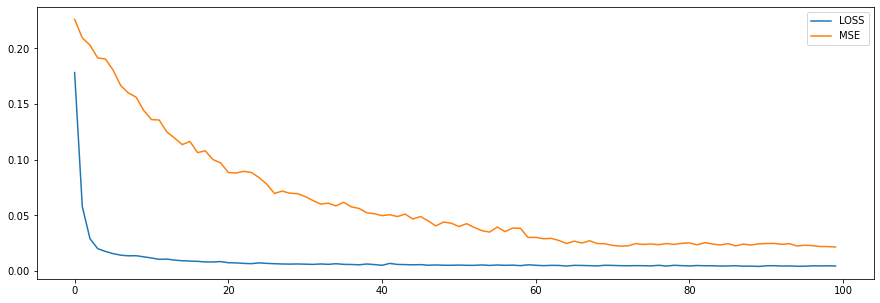

In [35]:
# params

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 12
lr = 2e-4
num_epochs = 100
n_layers = 2
input_size = 32
hidden_layer_size = 400
output_size = 5
bidirectional = False
dropout= 0.5

scaler = MinMaxScaler(feature_range=(-1, 1))
ts_scale = scaler.fit_transform(ts.values.reshape(-1, 1))
ts_scale = pd.Series(ts_scale.reshape(-1))

dataloader = dlDataset(ts=ts_scale, batch_size=batch_size, sample_length=input_size,
                       labels_length=output_size)

model = LSTM(num_layers=n_layers, input_size=input_size, 
             hidden_layer_size=hidden_layer_size, output_size=output_size, 
             bidirectional=bidirectional, dropout=dropout)

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss()

loss_history_epoch, loss_history_all_batch, metric_history_epoch = train_pipeline(model=model,
                                                                                  optimizer=optimizer,
                                                                                  loss_func=loss_func,
                                                                                  dataloader=dataloader,
                                                                                  num_epochs=num_epochs,
                                                                                  num_layers=n_layers,
                                                                                  bidirectional=bidirectional)


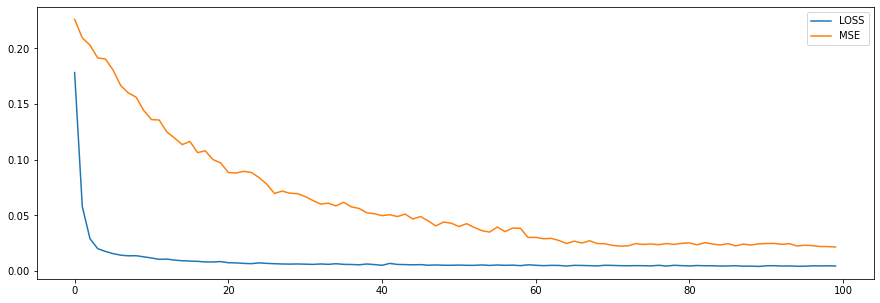

In [36]:
plt.figure(figsize=(15,5))
plt.plot(loss_history_epoch, label='LOSS')
plt.plot(metric_history_epoch, label='MSE')
plt.legend()

Точечный регрессор

[Epoch #99], LOSS: 0.004, MSE: 0.07


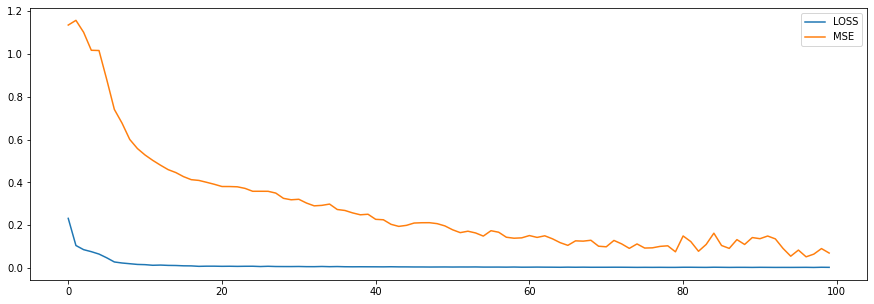

In [41]:
# params

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 12
lr = 2e-4
num_epochs = 100
n_layers = 4
input_size_dot = 14
hidden_layer_size = 200
output_size_dot = 1
bidirectional = False
dropout= 0.5

scaler = MinMaxScaler(feature_range=(-1, 1))
ts_scale = scaler.fit_transform(ts.values.reshape(-1, 1))
ts_scale = pd.Series(ts_scale.reshape(-1))

dataloader = dlDataset(ts=ts_scale, batch_size=batch_size, sample_length=input_size_dot,
                       labels_length=output_size_dot)

model_dot = LSTM(num_layers=n_layers, input_size=input_size_dot, 
             hidden_layer_size=hidden_layer_size, output_size=output_size_dot, 
             bidirectional=bidirectional, dropout=dropout)

optimizer = optim.Adam(model_dot.parameters(), lr=lr)
loss_func = nn.MSELoss()

loss_history_epoch, loss_history_all_batch, metric_history_epoch = train_pipeline(model=model_dot,
                                                                                  optimizer=optimizer,
                                                                                  loss_func=loss_func,
                                                                                  dataloader=dataloader,
                                                                                  num_epochs=num_epochs,
                                                                                  num_layers=n_layers,
                                                                                  bidirectional=bidirectional)

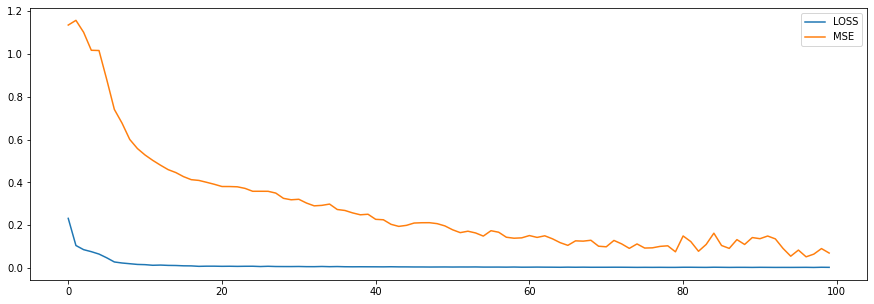

In [42]:
plt.figure(figsize=(15,5))
plt.plot(loss_history_epoch, label='LOSS')
plt.plot(metric_history_epoch, label='MSE')
plt.legend()

### Прогноз

Интервальный

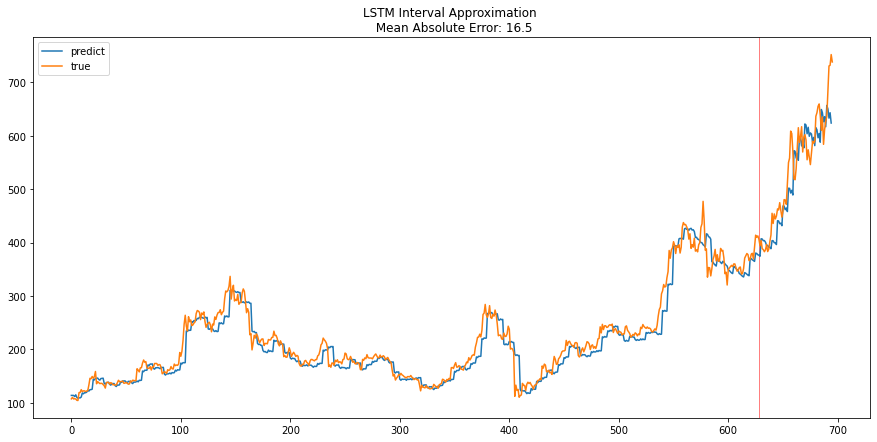

In [48]:
preds = []
model.eval()

idx_left = 0
idx_right = 0
for i in range((len(ts_scale)-input_size)//output_size):
    x = list(ts_scale)[idx_left:input_size+idx_right]
    seq = torch.FloatTensor(x).view(1, -1)

    with torch.no_grad():
        model.hidden = (torch.zeros(n_layers, 1, hidden_layer_size),
                        torch.zeros(n_layers, 1, hidden_layer_size))
        preds.append(model(seq).reshape(-1).tolist())

        idx_left+=output_size
        idx_right+=output_size

actual_predict = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
true_labels = scaler.inverse_transform(ts_scale[input_size:].values.reshape(-1, 1))

plt.figure(figsize=(15,7))
plt.plot(actual_predict, label='predict')
plt.plot(true_labels, label='true')
plt.title(f'LSTM Interval Approximation \n Mean Absolute Error: {mean_absolute_error(true_labels[:695], actual_predict):.1f}')
plt.axvspan(len(ts_scale)-90-10, len(ts_scale)-90-10, color = "red", alpha = 0.5)
plt.legend();

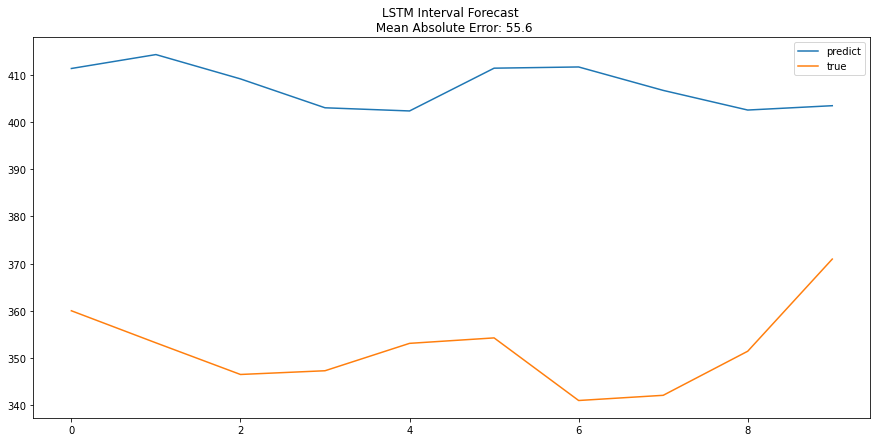

In [49]:
model.eval()

train = ts_scale[:-90]
x = train[-input_size:]
x = list(x)


for i in range(2):
    seq = torch.FloatTensor(x[-input_size:]).view(1, -1)

    with torch.no_grad():
        model.hidden = (torch.zeros(n_layers, 1, hidden_layer_size),
                        torch.zeros(n_layers, 1, hidden_layer_size))
        x +=(model(seq).reshape(-1).tolist())


actual_predict = scaler.inverse_transform(np.array(x).reshape(-1, 1))
true_labels = scaler.inverse_transform(ts_scale[-90:].values.reshape(-1, 1))

plt.figure(figsize=(15,7))
plt.plot(actual_predict[-10:], label='predict')
plt.plot(true_labels[:10], label='true')
plt.title(f'LSTM Interval Forecast \n Mean Absolute Error: {mean_absolute_error(true_labels[:10], actual_predict[-10:]):.1f}')
plt.legend();

Точечный прогноз

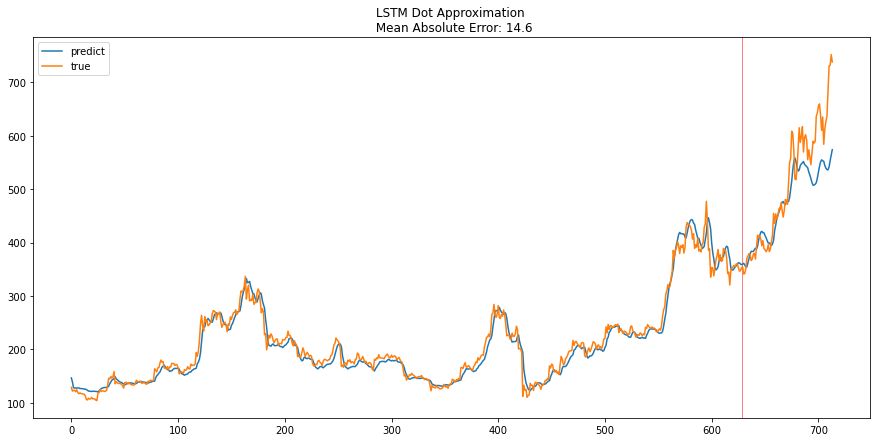

In [52]:
preds = []
model_dot.eval()

idx_left = 0
idx_right = 0
for i in range((len(ts_scale)-input_size_dot)//output_size_dot):
    x = list(ts_scale)[idx_left:input_size_dot+idx_right]
    seq = torch.FloatTensor(x).view(1, -1)

    with torch.no_grad():
        model_dot.hidden = (torch.zeros(n_layers, 1, hidden_layer_size),
                        torch.zeros(n_layers, 1, hidden_layer_size))
        preds.append(model_dot(seq).reshape(-1).tolist())

        idx_left+=output_size_dot
        idx_right+=output_size_dot

actual_predict = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
true_labels = scaler.inverse_transform(ts_scale[input_size_dot:].values.reshape(-1, 1))

plt.figure(figsize=(15,7))
plt.plot(actual_predict, label='predict')
plt.plot(true_labels, label='true')
plt.title(f'LSTM Dot Approximation \n Mean Absolute Error: {mean_absolute_error(true_labels, actual_predict):.1f}')
plt.axvspan(len(ts_scale)-90-10, len(ts_scale)-90-10, color = "red", alpha = 0.5)
plt.legend();

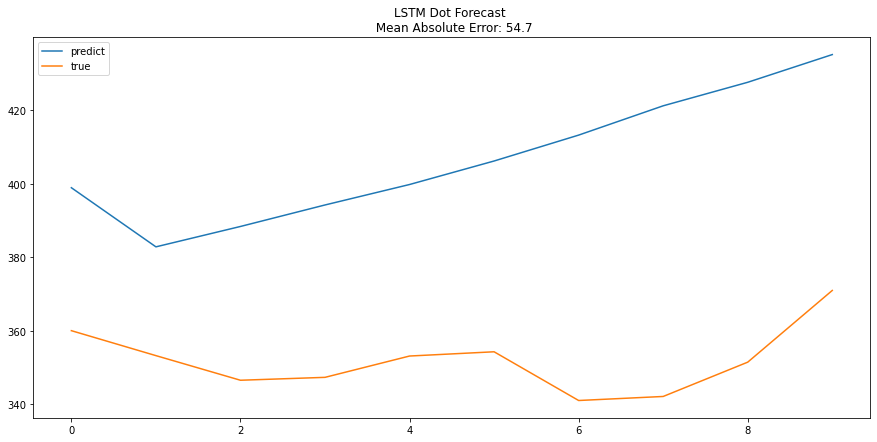

In [53]:
model.eval()

train = ts_scale[:-90]
x = train[-input_size_dot:]
x = list(x)


for i in range(10):
    seq = torch.FloatTensor(x[-input_size_dot:]).view(1, -1)

    with torch.no_grad():
        model_dot.hidden = (torch.zeros(n_layers, 1, hidden_layer_size),
                            torch.zeros(n_layers, 1, hidden_layer_size))
        x +=(model_dot(seq).reshape(-1).tolist())


actual_predict = scaler.inverse_transform(np.array(x).reshape(-1, 1))
true_labels = scaler.inverse_transform(ts_scale[-90:].values.reshape(-1, 1))

plt.figure(figsize=(15,7))
plt.plot(actual_predict[-10:], label='predict')
plt.plot(true_labels[:10], label='true')
plt.title(f'LSTM Dot Forecast \n Mean Absolute Error: {mean_absolute_error(true_labels[:10], actual_predict[-10:]):.1f}')
plt.legend();